<a href="https://colab.research.google.com/github/No-sign/Deep-pro/blob/main/copy_of_Your_Own_Chess%C2%A0AI_(Feedforward).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install peewee pytorch-lightning
!wget https://storage.googleapis.com/chesspic/datasets/2021-07-31-lichess-evaluations-37MM.db.gz
!gzip -d "2021-07-31-lichess-evaluations-37MM.db.gz"
!rm "2021-07-31-lichess-evaluations-37MM.db.gz"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2022-11-12 09:14:15--  https://storage.googleapis.com/chesspic/datasets/2021-07-31-lichess-evaluations-37MM.db.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1404305784 (1.3G) [application/x-gzip]
Saving to: ‘2021-07-31-lichess-evaluations-37MM.db.gz’

2021-07-31-lichess- 100%[===================>]   1.31G   221MB/s    in 6.4s    

2022-11-12 09:14:22 (210 MB/s) - ‘2021-07-31-lichess-evaluations-37MM.db.gz’ saved [1404305784/1404305784]

gzip: 2021-07-31-lichess-evaluations-37MM.db already exists; do you wish to overwrite (y or n)? n
	not overwritten


In [ ]:
from peewee import *
import base64

db = SqliteDatabase('2021-07-31-lichess-evaluations-37MM.db')

class Evaluations(Model):
  id = IntegerField()
  fen = TextField()
  binary = BlobField()
  eval = FloatField()

  class Meta:
    database = db

  def binary_base64(self):
    return base64.b64encode(self.binary)
db.connect()
LABEL_COUNT = 37000000
print(LABEL_COUNT)
eval = Evaluations.get(Evaluations.id == 1)
print(eval.binary_base64())

1000000
b'CAAAAAAAAAAQAAAAAAAAAIEAAAAAAAAAJAAAAAAAAABCAAAAAAAAAADvABAAAAAAAAAAAAAAAAgAAAAAAAAAEAAAAAAAAACBAAAAAAAAACQAAAAAAAAAQgAAAAAAAP8AAAABEz8='


In [ ]:
import os
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, IterableDataset, random_split
import pytorch_lightning as pl
from random import randrange

class EvaluationDataset(IterableDataset):
  def __init__(self, count):
    self.count = count
  def __iter__(self):
    return self
  def __next__(self):
    idx = randrange(self.count)
    return self[idx]
  def __len__(self):
    return self.count
  def __getitem__(self, idx):
    eval = Evaluations.get(Evaluations.id == idx+1)
    bin = np.frombuffer(eval.binary, dtype=np.uint8)
    bin = np.unpackbits(bin, axis=0).astype(np.single) 
    eval.eval = max(eval.eval, -15)
    eval.eval = min(eval.eval, 15)
    ev = np.array([eval.eval]).astype(np.single) 
    return {'binary':bin, 'eval':ev}    

dataset = EvaluationDataset(count=LABEL_COUNT)

In [ ]:
# Start tensorboard.
# %reload_ext tensorboard
# %tensorboard --logdir lightning_logs/

{'binary': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.,

In [ ]:
import time
from collections import OrderedDict

class EvaluationModel(pl.LightningModule):
  def __init__(self,learning_rate=1e-3,batch_size=1024,layer_count=10):
    super().__init__()
    self.batch_size = batch_size
    self.learning_rate = learning_rate
    layers = []
    for i in range(layer_count-1):
      layers.append((f"linear-{i}", nn.Linear(808, 808)))
      layers.append((f"relu-{i}", nn.ReLU()))
    layers.append((f"linear-{layer_count-1}", nn.Linear(808, 1)))
    self.seq = nn.Sequential(OrderedDict(layers))

  def forward(self, x):
    return self.seq(x)

  def training_step(self, batch, batch_idx):
    x, y = batch['binary'], batch['eval']
    y_hat = self(x)
    loss = F.l1_loss(y_hat, y)
    self.log("train_loss", loss)
    return loss

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

  def train_dataloader(self):
    dataset = EvaluationDataset(count=LABEL_COUNT)
    return DataLoader(dataset, batch_size=self.batch_size, num_workers=2, pin_memory=True)

configs = [
           # {"layer_count": 8, "batch_size": 1024},
           # {"layer_count": 6, "batch_size": 1024},
           # {"layer_count": 4, "batch_size": 1024},
           # {"layer_count": 6, "batch_size": 512},
           # {"layer_count": 8, "batch_size": 512},
            {"layer_count": 4, "batch_size": 512},
           ]
for config in configs:
  version_name = f'{int(time.time())}-batch_size-{config["batch_size"]}-layer_count-{config["layer_count"]}'
  logger = pl.loggers.TensorBoardLogger("lightning_logs", name="chessml", version=version_name)
  trainer = pl.Trainer(gpus=1,precision=16,max_epochs=1,auto_lr_find=True,logger=logger, accelerator='cpu')
  model = EvaluationModel(layer_count=config["layer_count"],batch_size=config["batch_size"],learning_rate=1e-3)
  # trainer.tune(model)
  # lr_finder = trainer.tuner.lr_find(model, min_lr=1e-6, max_lr=1e-3, num_training=25)
  # fig = lr_finder.plot(suggest=True)
  # fig.show()
  trainer.fit(model)
  break

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:705: UserWarning: You passed `Trainer(accelerator='cpu', precision=16)` but native AMP is not supported on CPU. Using `precision='bf16'` instead.
  "You passed `Trainer(accelerator='cpu', precision=16)` but native AMP is not supported on CPU."
INFO:pytorch_lightning.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
/usr/local/lib/python3.7/dist-packages/lightning_lite/accelerators/cuda.py:159: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
INFO:pytorch_lightning.utilities.rank_zero:GPU available:

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/lightning_lite/utilities/data.py:64: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
  "Your `IterableDataset` has `__len__` defined."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Idx 698266 Eval 4.04 Prediction 12.19 Loss 8.15
FEN k1n2Q2/Pr6/1P6/8/2q2P2/6RK/8/6R1 b - - 3 60


<IPython.core.display.SVG object>

Idx 702320 Eval -0.06 Prediction -2.01 Loss 1.95
FEN 2kr1b1r/pp3ppp/5n2/4Nb2/2P5/P1N5/1P1B1PPP/R2K3R b - - 1 12


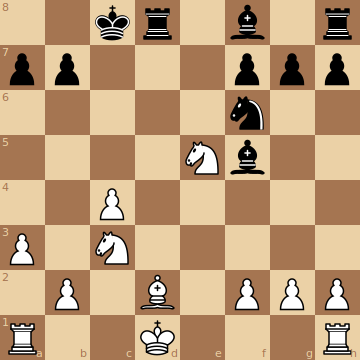

Idx 789241 Eval -4.55 Prediction -2.65 Loss 1.90
FEN r2r4/1p3pkp/p2n2pn/2P2b2/8/2N5/PP2BPPP/3R1RK1 b - - 0 20


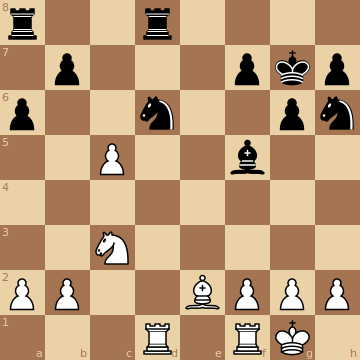

Idx 198245 Eval -0.53 Prediction 0.45 Loss 0.98
FEN 1k3r2/1pp5/p5p1/2q3pp/4p3/2P3QP/PP3PP1/3R2K1 w - - 0 27


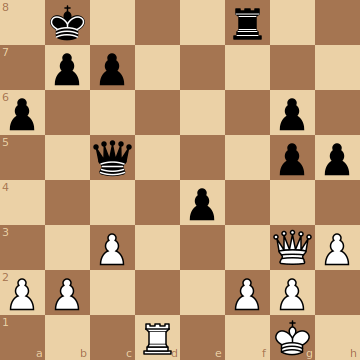

Idx 269804 Eval 10.93 Prediction 5.44 Loss 5.49
FEN 7k/pp3Q2/6p1/3p3p/6P1/5P2/PPq1R3/5K2 b - - 0 29


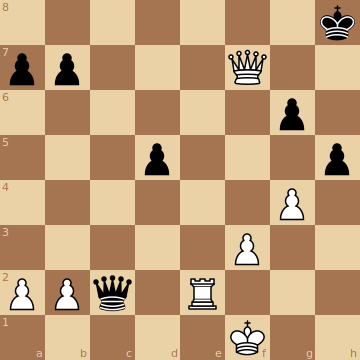

In [ ]:
from IPython.display import display, SVG
from random import randrange


SVG_BASE_URL = "https://us-central1-spearsx.cloudfunctions.net/chesspic-fen-image/" 

def svg_url(fen):
  fen_board = fen.split()[0]
  return SVG_BASE_URL + fen_board

def show_index(idx):
  eval = Evaluations.select().where(Evaluations.id == idx+1).get()
  batch = dataset[idx]
  x, y = torch.tensor(batch['binary']), torch.tensor(batch['eval'])
  y_hat = model(x)
  loss = F.l1_loss(y_hat, y)
  print(f'Idx {idx} Eval {y.data[0]:.2f} Prediction {y_hat.data[0]:.2f} Loss {loss:.2f}')
  print(f'FEN {eval.fen}')
  display(SVG(url=svg_url(eval.fen)))

for i in range(5):
  idx = randrange(LABEL_COUNT)
  show_index(idx)

# need to do better on "tactics" like 700756

In [ ]:
!pip install chess
import chess

MATERIAL_LOOKUP = {chess.KING:0,chess.QUEEN:9,chess.ROOK:5,chess.BISHOP:3,chess.KNIGHT:3,chess.PAWN:1}

def avg(lst):
    return sum(lst) / len(lst)

def material_for_board(board):
  eval = 0.0
  for sq, piece in board.piece_map().items():
    mat = MATERIAL_LOOKUP[piece.piece_type] 
    if piece.color == chess.BLACK:
      mat = mat * -1
    eval += mat
  return eval
  
def guess_zero_loss(idx):
  eval = Evaluations.select().where(Evaluations.id == idx+1).get()
  y = torch.tensor(eval.eval)
  y_hat = torch.zeros_like(y)
  loss = F.l1_loss(y_hat, y)
  return loss

def guess_material_loss(idx):
  eval = Evaluations.select().where(Evaluations.id == idx+1).get()
  board = chess.Board(eval.fen)
  y = torch.tensor(eval.eval)
  y_hat = torch.tensor(material_for_board(board))
  loss = F.l1_loss(y_hat, y)
  return loss

def guess_model_loss(idx):
  eval = Evaluations.select().where(Evaluations.id == idx+1).get()
  batch = dataset[idx]
  x, y = torch.tensor(batch['binary']), torch.tensor(batch['eval'])
  y_hat = model(x)
  # print(y_hat)
  loss = F.l1_loss(y_hat, y)
  return loss

zero_losses = []
mat_losses = []
model_losses = []
for i in range(100000):
  idx = randrange(LABEL_COUNT)
  zero_losses.append(guess_zero_loss(idx))
  mat_losses.append(guess_material_loss(idx))
  model_losses.append(guess_model_loss(idx))
print(f'Guess Zero Avg Loss {avg(zero_losses)}')
print(f'Guess Material Avg Loss {avg(mat_losses)}')
print(f'Guess Model Avg Loss {avg(model_losses)}')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 148 kB 7.5 MB/s 
Guess Zero Avg Loss 6.52910041809082
Guess Material Avg Loss 4.730602264404297
Guess Model Avg Loss 2.9359211921691895
